In [360]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.sparse.linalg import norm
from scipy.linalg import eigh_tridiagonal
from sklearn.cluster import KMeans

### Lanczos

In [921]:
def gs( vectors ):
    basis = []
    
    for v in vectors:
        w = v - np.sum( np.dot( v, b ) * b  for b in basis )
        if (w > 1e-10).any():  
            basis.append( w / np.linalg.norm(w) )
    
    return np.array( basis )

def Lanczos_step( A, T, Q, m0 = 0, m = 20):
    """
    Lanczos method implementation
    m0 - Z_ini
    m - Z_ini + Z_aug
    """
    v    = Q[0, :]
    w0   = A.dot( v )
    alfa = np.dot( w0.T, v )
    w    = w0 - np.dot( alfa, v )
    
    for j in range( m0, m - 1 ):
        beta = np.linalg.norm( w )
        v0   = v
        v    = w / beta
        w0   = A.dot( v )
        alfa = np.dot( w0.T, v )
        w    = w0 - np.dot( alfa, v ) - np.dot( beta, v0 )
        T[j, j]     = alfa
        T[j, j + 1] = beta
        T[j + 1, j] = beta
        Q[j, :]     = v
    
    beta = np.linalg.norm( w )
    v0   = v
    v    = w / beta
    w0   = A.dot( v )
    alfa = np.dot( w0.T, v )
    w    = w0 - np.dot( alfa, v ) - np.dot( beta, v0 )
    T[m - 1, m - 1] = alfa
    Q[m - 1, :]     = v
    
    return T, Q

### Lanczos-IO

In [1018]:
## input:
#      M - real symmetric matrix
#      Z_ini - # of initial Lanczos vectors
#      Z_aug - # of augmented Lanczos vectors
## output
#      evals, evecs - K-leading eigenpairs
def Lanczos_IO( M, T, Q, K_min, Z_ini = 20, Z_aug = 10, rule_of_stop = None ):
    """Lanczos-IO algorithm (2) implementation"""
    K    = 1
    Flag = 1
    n    = M.shape[0]
    Z = 0
    
    v0 = np.random.rand( n )
    v0 = v0 / np.linalg.norm( v0 )
    v = L.dot( v0 )
    v = v - np.dot( v, v0 ) * v0
    v = v / np.linalg.norm( v )

    T, Q = np.zeros( (Z_ini, Z_ini) ), np.zeros( (Z_ini, n) )
    Q[0, :] = v
    lead_evals, lead_evecs = np.zeros( K_min ), np.zeros( (n, K_min) )
    
    while Flag == 1:
        T, Q = Lanczos_step( L, T, Q, m0 = Z, m = Z_ini )
        diag                   = T.diagonal()
        off_diag               = T.diagonal(1)
        real_evals, real_evecs = eigh_tridiagonal( diag, off_diag )
        real_epairs_relation = real_evals.argsort()
        
        error = abs( np.dot( T[Z_ini - 2, Z_ini - 1], real_evecs[Z_ini - 1, K - 1] ) )
        tolerance = np.finfo(np.float64).eps * norm( M, ord = np.inf )
        
        print( "Residual error: {}".format( error - tolerance ) )
        
        if error > tolerance:
            Z = Z_ini
            Z_ini = Z_ini + Z_aug
            T.resize( (Z_ini, Z_ini), refcheck = False )
            Q.resize( (Z_ini, n), refcheck = False )
            continue
        
        if K >= K_min or rule_of_stop is not None and rule_of_stop( T, Q ) == False:
            Flag = 0
            lead_evals = real_evals[real_epairs_relation][-K:]
            for j in range( K ):
                lead_evecs[:, j] = Q.T.dot( real_evecs[real_epairs_relation][-j] )
        else:            
            K = K + 1
            continue
    
    return lead_evals, lead_evecs, K

### Clusterization

In [432]:
def Spectral_Clusterization_IO(evecs, current_cluster_cnt):
    kmeans_partition = KMeans(n_clusters = current_cluster_cnt, random_state=0).fit(evecs).labels_
    # create input of a quality function (communities - further rule_of_stop argument)
    communities = {i:set() for i in range(current_cluster_cnt)}
    for idx, cluster_num in enumerate(kmeans_partition):
        communities[cluster_num].add(idx)
    communities = list(communities.values())
    
    return kmeans_partition

## Tests

### Lanczos

In [808]:
L = np.array( [ [2., -1, -1, 0, 0, 0, 0, 0, 0, 0],
                [-1, 2, -1, 0, 0, 0, 0, 0, 0, 0],
                [-1, -1, 3, -1, 0, 0, 0, 0, 0, 0],
                [0, 0, -1, 4, -1, 0, -1, 0, 0, -1],
                [0, 0, 0, -1, 4, -1, -1, -1, 0, 0],
                [0, 0, 0, 0, -1, 3, -1, -1, 0, 0],
                [0, 0, 0, -1, -1, -1, 6, -1, -1, -1],
                [0, 0, 0, 0, -1, -1, -1, 4, 0, -1],
                [0, 0, 0, 0, 0, 0, -1, 0, 2, -1],
                [0, 0, 0, -1, 0, 0, -1, -1, -1, 4] ] )

real_evals, real_evecs = np.linalg.eig(L)
real_evals.sort()

print(real_evals)

[-1.11022302e-16  3.06851215e-01  1.72406597e+00  2.81086785e+00
  3.00000000e+00  3.78467863e+00  4.33735483e+00  4.84264371e+00
  6.14394237e+00  7.04959542e+00]


In [809]:
L = sparse.csr_matrix( L )

v0 = np.random.rand( 10 )
v0 = v0 / np.linalg.norm( v0 )
v = np.array(L.todense()).dot( v0 ).flatten()
v = v - np.dot( v, v0 ) * v0
v = v / np.linalg.norm( v )

T, Q = np.zeros( (10, 10) ), np.zeros( (10, 10) )
Q[0, :] = v

T_new, Q_new = Lanczos_step( L, T, Q, m0 = 0, m = 10 )
diag = T_new.diagonal()
off_diag = T_new.diagonal(1)
real_evals2, real_evecs2 = eigh_tridiagonal( diag, off_diag )
real_evals2.sort()

print( real_evals2 )

[0.36058805 0.51091004 1.55158156 2.00986924 3.22029002 3.9065781
 4.8591076  5.02212907 5.48852338 7.55521023]


In [810]:
print( real_evals - real_evals2 )

[-0.36058805 -0.20405883  0.17248441  0.80099861 -0.22029002 -0.12189947
 -0.52175276 -0.17948535  0.65541899 -0.50561482]


### Lanczos_IO

Number of vertices = 34
Number of edges = 78


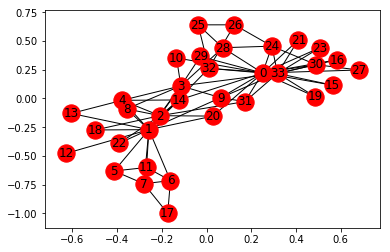

In [996]:
kn = nx.read_gml("data/karate.gml")

print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))

nx.draw_networkx(kn)

In [1019]:
A = nx.adjacency_matrix(kn)
L = sparse.diags(np.ravel(A.sum(0))).tocsr() - A

K = 3

real_evals3, vectors, current_cluster_cnt = Lanczos_IO( L, T, Q, K )
real_evals3.sort()

print( vectors.shape )

Residual error: 0.00019381092325646508
Residual error: -7.549516567451064e-15
Residual error: -7.549516567451064e-15
Residual error: -7.549516567451064e-15
Residual error: 0.09038894473264643
Residual error: -7.549516567451064e-15
Residual error: -7.549516567451064e-15
(34, 5)


In [1020]:
kmeans_partition = Spectral_Clusterization_IO( vectors, current_cluster_cnt )
print( kmeans_partition )

[4 3 2 0 2 1 3 2 2 3 0 2 2 1 2 0 2 1 2 0 1 0 0 0 4 2 2 2 2 1 2 2 2 1]


/Users/farewell/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


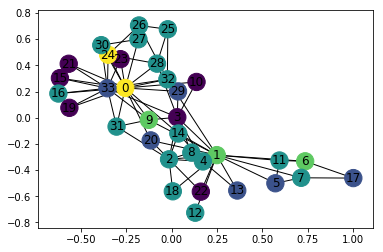

In [1021]:
nx.draw_networkx( kn, node_color = kmeans_partition )